# Peforming Physics Simulation on Remote Server

### Motivation
In the fluid modeling industry (oil and gas, water resources modeling), fluid flow simulations are often performed to simulate the flow of fluids through porous media (rocks in the subsurface) via 3-D numerical simulations. The simulations are important for planning and optimization of depletion of related resources. 

A third-party tool is usually used to perform the detailed fluid flow calculations. Usually, a user creates a set of files (specific to particular tool) and then calls the executable, which performs the flow calculations and then outputs some results. The user must have access to the 3rd-party tool which are very expensive. Additionally, the input files are very complicated to create, and manually creating these files can lead to errors. 

Over the last few years, I developed a large integrated application to perform the above tasks (in addition to others tasks). The application automates the creation of the required files and interaction with the 3rd-party applications. 
We have tested the application for specific benchmark models. 

### Introduction
This notebook describes the application of a scientific application for performing physics simulations on remote server with application in the oil and gas industry. We are using a simple benchmark reservoir simulation model with dimensions (100x1x1). This notebook does not describe the details of the physics simulation. The interested reader is referred to this article for a simple example. 


However, we note that all tests are performed on a single machine, i.e., the HTTP request application (this notebook) and servers are on the same machine. 

### Typical workflow
The public interface of the application consists of a python server (Django) that receives HTTP requests. The Django server then forwards the calls to the application server (not written in python) that is not accessible from the public API. 


The steps for a typical request are described as follows:

* Django server receives a request at a particular API endpoint. The HTTP post data includes of a **project_id** and other related data (physics data) for the specific simulation run. Django then makes a request to the application server.

* The application server receives the data and creates all the necessary files required to perform the simulation. 
    * The application server automatically generates several input files required by the third-party application that performs the physics simulation calculations.
    
    * The application server calls the 3rd party application to perform the simulation. It is also possible to receive requests for multiple simulations and these are performed in parallel (using multiple threads). The application server monitors each simulation job until completion.
        
    * After the simulation(s), the application server processes the output files for each simulation and encodes them using JSON notation. 
    * The application server returns the JSON encoded results to Django server. This marks the end of tasks performed by the application server for the incoming request. 
    
* Django server receives the results from the application server, updates relevant database tables, and forwards it to the user as a response to the API call. At this point, the user can then process the results. For example, in this notebook, we plot the production profiles for different quantities (see below). 

In other application, the results can be used in a optimization workflow where each API call is part of series of calls to compute the objective function of a given solution X, i.e., F(X).

### Application server
The application server is a large-scale integrated application (~260KLOC) that performs many complex tasks and calculations including performing remote simulations (described above), optimization, machine learning, amongst others. The development of the overall application is described in a paper and will be presented in a conference next year.

In the next section, we show an example usage for performing remote physics simulations. We have also provided some **project_id**. Please note the code in this notebook can note be run by another user because the experiments were done on local machine and the project_id below is tied to a particular username. The application will be developed to one of the cloud providers soon. 

### Benefits
* Improved and efficient workflow:

    * The application server is implemented in a compiled programming language .
    * We use the right **data structures** and **algorithms** to ensure efficient code and **multiprocessing** to improve computation efficiency.
    * Apply techniques so application can scale to millions of users that scale for millions of users (Not described in this notebook, but we have explored to use of Docker containers to automatically scale up/down the available computation servers). 

* Application codifies some of the knowlege and rules that experts use to interact with the 3rd-party tools.

* The application (when fully deployed) can be used by anyone in world with an access to the internet. Thus, the application will facililate global research, especially researchers and students from less developed countries to perform similar research as in the western universities because they will not have access to a critical research component. Additionally, they may not have access to or be able use the 3rd-party applications. Finally, most students do not have the expertise to use these advanced tools.

## Set up resources 

In [1]:
import requests
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
plt.figure(figsize=(8, 6), dpi=80)

from remote_sim_plot_utils import plot_field_results, plot_producer_results, plot_injector_results


<Figure size 640x480 with 0 Axes>

In [2]:
# print json with indentation
def print_json(data, indent=4):
    print(json.dumps(data, indent=indent))

def make_plots(sim_results):
    if sim_results:
        field_results = sim_results["field_results"]
        well_results = sim_results["well_results"]
        well_names   = sim_results["well_names"]
        plot_field_results(sim_results)
        plot_producer_results(sim_results)
        plot_injector_results(sim_results)
                
def make_performance_plot(df, title='Calls', out_filename='out.png'):
    #plt.figure(figsize=(12, 10), dpi=80)
    fontsize=15
    plt.plot(df)
    plt.xlabel('Simulation Index', fontsize=fontsize)
    plt.ylabel('Duration (seconds)', fontsize=fontsize)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim([0, len(df)])
    plt.ylim([0, 10])
    plt.title(title,fontsize=fontsize)
    plt.legend(df.columns, fontsize=fontsize)
    plt.grid(True)
    if out_filename:
        plt.savefig('./output/' + out_filename)

## Setup 

We set the server API, project_ids, and sample file that contains the data for the physics simulation.

### Server APIs

In [3]:
DJANGO_SERVER_API = "http://127.0.0.1:8000/simapi/run-sim-json/"
APP_SERVER_API    = "http://127.0.0.1:8081/api/sim/run-sim-json"

### Set project_id key to specify what simulation project

In order to perform a remote simulation, a user must first create a **project_id** key that is tied to a simulation model. This key enables selecting and performing simulation for the same model afterwards. 

In [4]:
# set a project_id key to run the xz-nz-model. The dimensions of the model are (100x1x1)
project_id = "084de6a9-03b8-4eb2-bbe6-3407eda32b20"

### Sample input file with parameters to run application

Here we read the sample input file that contains relevant simulation parameters, e.g., well locations, type of results to be returned, etc

In [5]:
input_file = "sample-input-files/xz_nz_model_v2_formatted_valid.json"
with open(input_file) as f:
    input_data = json.dumps(json.load(f))
#print_json(input_data)

### HTTP Request to Django Server

Here we make an HTTP Post request to the Django server.

In [6]:
response = requests.post(DJANGO_SERVER_API, data={'project_id':project_id, 'input_data': str(input_data)})
if response.status_code == 200:
    print('Success: Remote simulation job completed')
    response_json = response.json()
    #print_json(response_json)
    sim_results = response_json[0]    
else:
    print('Failed: Remote simulation job failed')

Success: Remote simulation job completed
[
    {
        "real_id": 1,
        "status": "SUCCESS",
        "case": "case-cdef240d3a556e0",
        "job_start_time": "202196 17:49:30.665820 GMT-05:00",
        "job_end_time": "202196 17:49:33.760628 GMT-05:00",
        "duration": 3.094852,
        "job_directory": "/tmp/simulations/case-cdef240d3a556e0",
        "deleted": "NO",
        "cum_oil": 602367.16,
        "npv": 7409165.5,
        "well_names": [
            "PROD-1",
            "PROD-2",
            "INJE-1"
        ],
        "producer_well_names": [
            "PROD-1",
            "PROD-2"
        ],
        "injector_well_names": [
            "INJE-1"
        ],
        "well_results": {
            "PROD-1": {
                "unit-system": "FIELD",
                "time-days": [
                    0.0,
                    1.0,
                    2.978797,
                    7.303366,
                    13.25132,
                    18.45103,
                  

### HTTP Post to application server directly

Here we make an HTTP Post to the application directly. Normally, it will not be possible to access the aplication server directly. I have included this test to identify latency problems and bottle necks between Django server and application server.

#### Sample parameters


In [7]:
# Set parameters for sample call to application server
# Need to derive some of the other data from the database
# TODO: Update the application code so we derive that data from the database
# TODO: Reduce data that is specified as part of the of input data
data = {
    "user-id": 1,
    "project-id": "084de6a9-03b8-4eb2-bbe6-3407eda32b20",
    "model-name": "xz-nz-model",
    "model-version": "v2.1.7",
    "model-directory": "apisds/production_models/v2.1.7/xz-nz-model/",
    "eval-host-ip": "localhost",
    "real-ids": [
        1
    ],    
    "max-num-real": 1,
    "delete": "NO",
    "server-port": 50100,
    "json-file-data": input_data,
}
data = json.dumps(data)

In [8]:
# view sample data
print(data)

{"user-id": 1, "project-id": "084de6a9-03b8-4eb2-bbe6-3407eda32b20", "model-name": "xz-nz-model", "model-version": "v2.1.7", "model-directory": "apisds/production_models/v2.1.7/xz-nz-model/", "eval-host-ip": "localhost", "real-ids": [1], "max-num-real": 1, "delete": "NO", "server-port": 50100, "json-file-data": "{\"projectid\": \"66333aca-b53a-4ced-bf41-9c06a75bc643\", \"delete\": \"NO\", \"field-results\": \"YES\", \"well-results\": \"YES\", \"results\": [\"npv\", \"cop\"], \"parameters\": [[{\"welltype\": 0, \"heel\": [1, 1, 1], \"toe\": [1, 1, 1]}, {\"welltype\": 1, \"heel\": [50, 1, 1], \"toe\": [50, 1, 1]}, {\"welltype\": 0, \"heel\": [100, 1, 1], \"toe\": [100, 1, 1]}]]}"}


#### Call the application server (and make plot of results if successful)

Success: Remote simulation job executed


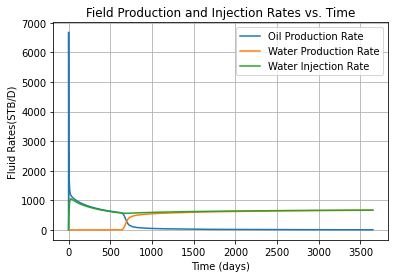

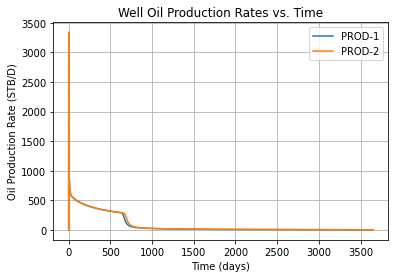

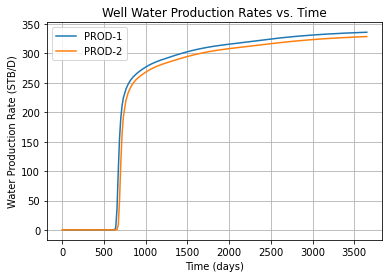

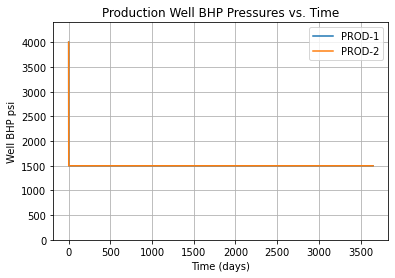

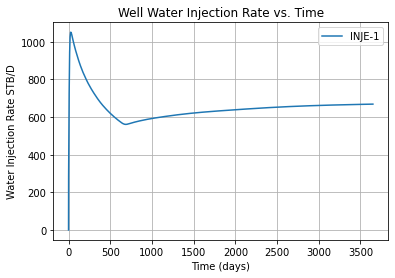

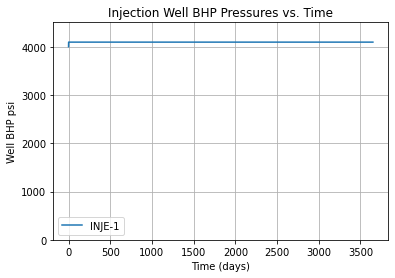

In [9]:
response = requests.post(APP_SERVER_API, data=data)
if response.status_code == 200:
    print('Success: Remote simulation job executed')
    response_json = response.json()
    # Extract the field results
    sim_results = response_json[0]
    make_plots(sim_results)    
else:
    print('Failed: Remote simulation job failed')


### Simulate multiple serial calls to remote servers 

Here we perform a simulation of perform several serial calls to the remote servers (Django and application). The goal of the tests is to test the performance of calls. 

It should be noted that this is a limited test as the Django and application servers are on the same Linux machine. 


We performed simulations with 500 calls to the Django and application servers respectively. The simulation tracks the HTTP response times for each of the 500 requests to both servers (see plot of results below). 

In general, the response time for the requests is approximately 2 seconds. Since, the Django application always calls the application server, there is not a lot of latency in this case. The spikes in the results can be attributed to the fact that the test Linux box was running other applications, so occasionally we see spikes in the response times. 

Please note that this is a limited test as HTTP requests and servers (Django and application) reside on the same Linux machine.




### Future work: Test performance with servers hosted on cloud

Next, we will perform an analyses with the servers deployed on the cloud to simulate real application usage. 

### HTTP Response Duration: Django vs. Application Server

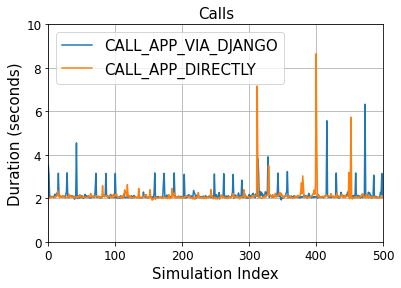

In [10]:
df = pd.read_csv('./output/serial_remote_calls_500.csv')
make_performance_plot(df)

In [11]:
# set the number of calls: 0 disables making the calls again
num_calls = 0

In [12]:
# call the django server
def run_django_server(num_calls=num_calls):
    django_durations = np.zeros(num_calls)
    for i in range(num_calls):
        response = requests.post(DJANGO_SERVER_API, data={'project_id':project_id, 'input_data': str(input_data)})
        results = response.json()
        django_durations[i] = results[0]['duration']
    return django_durations


In [13]:
# call the application server 
def run_app_server(num_calls=num_calls):
    app_durations = np.zeros(num_calls)
    for i in range(num_calls):
        response = requests.post(CL_APP_SERVER_API, data=data)
        results = response.json()
        app_durations[i] = results[0]['duration']
    return app_durations


In [14]:
# run simulations
def run_serial_test(num_calls=num_calls):
    django_durations = run_django_server(num_calls)
    app_durations    = run_app_server(num_calls)
    df = pd.DataFrame({'CALL_APP_VIA_DJANGO' : django_durations, 'CALL_APP_DIRECTLY' : app_durations})
    if num_calls > 0:
        make_performance_plot(df, title='Serial Remote Calls')
    return df

def run_app_serial_test(num_calls=num_calls):
    app_durations    = run_app_server(num_calls)
    df = pd.DataFrame({'CALL_APP_DIRECTLY' : app_durations})
    if num_calls > 0:
        make_performance_plot(df, title='Serial Remote Calls')
    return df


In [15]:
df = run_serial_test(num_calls)